In [1]:
import tensorflow as tf

print(tf.__version__)

2.1.0


In [2]:
import numpy as np
import tensorflow as tf

# Numpy
random1 = np.random.rand(2,2)
print(random1)

# Tensorflow
random2 = tf.random.normal([1], dtype=tf.float32)
print(random2)
# TF 1.x 버전에서는 Node가 가지는 값을 얻어오려면
# Session이 필요했음
# TF 2.x 버전에서는 Session 없이 즉시 실행(Eager Execution)
print(random2.numpy())

[[0.62323538 0.28094194]
 [0.61968519 0.20786151]]
tf.Tensor([0.7794295], shape=(1,), dtype=float32)
[0.7794295]


In [3]:
import tensorflow as tf

a = tf.constant(10, dtype=tf.float32)
b = tf.constant(20, dtype=tf.float32)

c = a + b

print('c의 값은 : {}'.format(c.numpy()))

d = 30.0

tensor_d = tf.convert_to_tensor(d)
print((c + tensor_d).numpy())

c의 값은 : 30.0
60.0


In [4]:
import tensorflow as tf

W = tf.Variable(tf.random.normal([1]), name='weight')

# 기존에는 tf.Variable()을 이용해서 변수를 만들면 사용하기 전에
# 초기화를 반드시 진행해야 했음
# sess.run(tf.global_valriables_initializer())
# TF 2.0에서는 초기화를 할 필요가 없음
print(W.numpy())

[0.23765859]


In [ ]:
# tensorflow graph에 입력을 주는 부분이 사라짐
# 기존에는 graph에 데이터를 밀어넣기 위해서 placeholder를 이용했음
# Eager Execution에 의해서 이제는 placeholder를 필요없어졌음

# Lazy Execution을 하지 않고 이제부턴 Eager Execution을 수행

In [ ]:
# tensorflow의 keras를 이용해서 model 생성
import tensorflow as tf

# keras model 생성
model = tf.keras.models.Sequential()

# model 안에 layer를 생성
model.add(tf.keras.layers.Flatten(input_shape=(2,)))       # input layer
model.add(tf.keras.layers.Dense(3, activation='softmax'))  # output layer

# model compile 과정
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])

# tensorflow는 내 loss를 따로 구현해서 넣을 수 있음
# sklearn과의 차이!!
def my_loss:
    pass

# model 학습
model.fit(x_data_train, t_data_train, epochs=100, batch_size=100, validation_split=0.3)

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Raw Data Loading
df = pd.read_csv('./data/ozone.csv')

print(df.isnull().sum())

Ozone      37
Solar.R     7
Wind        0
Temp        0
Month       0
Day         0
dtype: int64


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Raw Data Loading
df = pd.read_csv('./data/bmi.csv', skiprows=3)

# Data Split
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df[['height','weight']], df['label'], test_size=0.3, random_state=0)

# Normalization
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

# Multinomial Logistic Regression
model = LogisticRegression()
model.fit(x_data_train_norm, t_data_train)
print(model.score(x_data_test_norm, t_data_test))

# KNN을 이용한 분류
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_data_train_norm, t_data_train)
print(knn_model.score(x_data_test_norm, t_data_test))

0.9845
0.998


In [36]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import warnings

# Raw Data Loading
df = pd.read_csv('./data/ozone.csv')

training_data = df   # 원본 보존
x_data = training_data[['Solar.R','Wind','Temp']]
t_data = training_data['Ozone']

# 결측치 확인
# print(df.isnull().sum())

# 독립변수에 대한 결측치 처리
# 1. Solar.R에 7개의 결측치가 존재하는데 meian으로 처리
for col in x_data.columns:
    col_median = np.nanmedian(x_data[col])   # np.nanmedian => nan제외하고 median구하는 함수
    x_data[col].loc[x_data[col].isnull()] = col_median

# 2. 독립변수에 대한 이상치 검출 후 이 이상치는 mean 처리
zscore = 1.8

for col in x_data.columns:
    outliers = x_data[col][np.abs(stats.zscore(x_data[col])) > zscore]
    col_mean = np.mean(x_data.loc[~x_data[col].isin(outliers), col])   # 각 컬럼에서 이상치가 아닌 데이터들의 평균
    x_data.loc[x_data[col].isin(outliers), col] = col_mean   # 이상치 값들을 위에서 구한 평균으로 대체

# 3. 정규화
scaler_x = MinMaxScaler()
scaler_t = MinMaxScaler()

scaler_x.fit(x_data.values)
scaler_t.fit(t_data.values.reshape(-1,1)) # 2차원 형태

x_data_norm = scaler_x.transform(x_data)
t_data_norm = scaler_t.transform(t_data.values.reshape(-1,1)).ravel() # 2차원 형태인데 나중에 1차원으로 사용되어야 함

# 4. 종속변수에 대한 결측치는 KNN을 이용해서 예측값으로 imputation
#    학습에 사용할 x_data_train_norm, t_data_train_norm을 구해야함
x_data_train_norm = x_data_norm[~np.isnan(t_data_norm)]   # t_data_norm에 NaN 값이 있는 row를 제외하고 x_data_train_norm으로 생성
t_data_train_norm = t_data_norm[~np.isnan(t_data_norm)]

# KNN 모델 생성 후 fitting
knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(x_data_train_norm, t_data_train_norm)

# Predict
knn_predict = knn_regressor.predict(x_data_norm[np.isnan(t_data_norm)])
t_data_norm[np.isnan(t_data_norm)] = knn_predict

# 학습 진행

from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

test_data = [[310, 15, 80]]

# sklearn
sklearn_model = LinearRegression()
sklearn_model.fit(x_data_norm, t_data_norm)
result = sklearn_model.predict(scaler_x.transform(test_data)).reshape(-1,1) # 아래에서 다시 transform하기 위해 2차원으로
final_result = scaler_t.inverse_transform(result)  # 정규화된 형태를 다시 원래대로
print('sklearn의 결과 : {}'.format(final_result))

# Tensorflow 2.x
# 모델 생성
keras_model = Sequential()

# 레이어 추가
keras_model.add(Flatten(input_shape=(3,)))
keras_model.add(Dense(1, activation='linear'))

# compile
keras_model.compile(optimizer=SGD(learning_rate=1e-2), loss='mse')

# 학습
keras_model.fit(x_data_norm, t_data_norm,
                epochs=500, verbose=0)   # verbose는 epoch마다의 결과를 보여줌

# 예측
result = keras_model.predict(scaler_x.transform(test_data)).reshape(-1,1)
final_result = scaler_t.inverse_transform(result)
print('tensorflow의 결과 : {}'.format(final_result))

sklearn의 결과 : [[38.75927452]]
tensorflow의 결과 : [[27.985199]]


In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy import stats

# Raw Data Loading
df = pd.read_csv('./data/titanic/train.csv')

# Feature Engineering
# 필요없는 column 삭제
df = df.drop(['PassengerId','Name','Ticket','Cabin','Fare'], axis=1, inplace=False)

# 하나로 합칠 수 있는 column 처리
df['Family'] = df['SibSp'] + df['Parch']
df.drop(['SibSp','Parch'], axis=1, inplace=True)

# 문자로 되어 있는 column을 숫자로 변환
sex_dict = { 'male' : 0, 'female' : 1 }
df['Sex'] = df['Sex'].map(sex_dict)

embarked_dict = {'S' : 0, 'C' : 1, 'Q' : 2}
df['Embarked'] = df['Embarked'].map(embarked_dict)

# # 결측치 처리
# Age에 177개의 결측치, Embarked에 결측치 2
# Age는 median, Embarked는 mode를 이용하여 결측치 처리
df.loc[df['Age'].isnull(),'Age'] = np.nanmedian(df['Age'].values)
mode_result = stats.mode(df['Embarked'],nan_policy='omit')[0].ravel()   # nan_policy='omit'은 nan일 경우 무시하는 옵션
df.loc[df['Embarked'].isnull(),'Embarked'] = mode_result[0]

# 이상치 확인
# zscore = 1.8

# for col in df.columns:
#     outliers = df.loc[np.abs(stats.zscore(df[col])) >= zscore,col]
#     print('Col : {}에 이상치 : {}개'.format(col,outliers.sum()))
#     print('outliers : {}'.format(outliers))
# 실제로 이상치가 검출되지만 사실값이기 때문에 수정하지 않음.

def age_category(age):
    if ((age >=0) & (age<25)):
        return 0
    elif ((age >=25) & (age<50)):
        return 1
    else:
        return 2

df['Age'] = df['Age'].map(age_category)    

#################################################

# data split

x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('Survived', axis=1, inplace=False), df['Survived'], test_size=0.3, random_state=0)

# Normalization
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

##################

# sklearn으로 모델 구현
sklearn_model = LogisticRegression()    # model 생성
sklearn_model.fit(x_data_train_norm,t_data_train)  # model 학습
sklearn_result = sklearn_model.score(x_data_test_norm,t_data_test)

print('sklearn의 정확도는 : {}'.format(sklearn_result))

# tensorflow 2.x로 구현
keras_model = Sequential()

keras_model.add(Flatten(input_shape=(x_data_train_norm.shape[1],)))
keras_model.add(Dense(1, activation='sigmoid'))

keras_model.compile(optimizer=SGD(learning_rate=1e-3),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

result = keras_model.fit(x_data_train_norm,
                         t_data_train,
                         epochs=1000,
                         verbose=0,
                         validation_split=0.3)

keras_result = keras_model.evaluate(x_data_test_norm,t_data_test)
print('TF2.0의 정확도는 : {}'.format(keras_result))

Survived    0
Pclass      0
Sex         0
Age         0
Embarked    0
Family      0
dtype: int64
sklearn의 정확도는 : 0.7947761194029851
268/268 [==============================] - 0s 63us/sample - loss: 0.5530 - accuracy: 0.7649
TF2.0의 정확도는 : [0.5530340627058229, 0.76492536]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


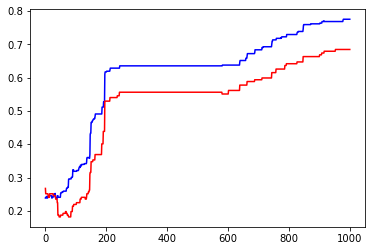

In [40]:
import matplotlib.pyplot as plt

print(result.history.keys())

plt.plot(result.history['accuracy'], color='b')
plt.plot(result.history['val_accuracy'], color='r')
plt.show()  # overfitting 발생

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression  # multinomial 구현도 이걸 이용
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

# Raw Data Loading
df = pd.read_csv('./data/digit-recognizer/train.csv')

# 결측치나 이상치는 없음
# Feature Engineering 할 필요가 없음

# 독립변수와 종속변수 분리
x_data = df.drop('label', axis=1, inplace=False)
t_data = df['label']   # one-hot encoding 해야하는데 일단 보류

# Normalization
scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

# Data Split
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(x_data_norm,t_data,test_size=0.3, random_state=0)

# Model 생성
sklearn_model = LogisticRegression(solver='saga')
# solver라는 개념이 있는데 default로 사용되는건 lbfgs
# lbfgs : 작은 데이터셋에 좋아요!, 데이터량이 많으면 성능이 별로임
# 데이터량이 많은 경우 sag(Stochastic Average Gradient Descent)를 사용하면 더 좋음
# 일반적으로 또 이걸 개량한 saga를 더 많이 이용

sklearn_model.fit(x_data_train,t_data_train)  # 학습진행
print('sklearn result :')
print(classification_report(t_data_test, 
                            sklearn_model.predict(x_data_test)))

# TF 2.0 구현
keras_model = Sequential()
keras_model.add(Flatten(input_shape=(x_data_train.shape[1],)))
keras_model.add(Dense(10, activation='softmax'))

keras_model.compile(optimizer=SGD(learning_rate=1e-2),
                    loss='sparse_categorical_crossentropy',   # sparse를 붙여주면 one-hot encoing 작업을 생략 가능
                    metrics=['sparse_categorical_accuracy'])

history = keras_model.fit(x_data_train,
                          t_data_train,
                          epochs=500,
                          batch_size=100,
                          verbose=0,
                          validation_split=0.3)

print('tensorflow result :')
print(keras_model.evaluate(x_data_test,t_data_test))

sklearn result :
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1242
           1       0.95      0.97      0.96      1429
           2       0.92      0.90      0.91      1276
           3       0.91      0.90      0.90      1298
           4       0.92      0.92      0.92      1236
           5       0.88      0.88      0.88      1119
           6       0.93      0.96      0.94      1243
           7       0.94      0.93      0.94      1334
           8       0.89      0.88      0.88      1204
           9       0.89      0.89      0.89      1219

    accuracy                           0.92     12600
   macro avg       0.92      0.92      0.92     12600
weighted avg       0.92      0.92      0.92     12600

tensorflow result :
12600/12600 [==============================] - 0s 36us/sample - loss: 0.2886 - sparse_categorical_accuracy: 0.9204
[0.28857140054778446, 0.9203968]


              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1242
           1       0.96      0.97      0.97      1429
           2       0.93      0.90      0.91      1276
           3       0.91      0.89      0.90      1298
           4       0.92      0.92      0.92      1236
           5       0.89      0.88      0.88      1119
           6       0.92      0.97      0.94      1243
           7       0.94      0.93      0.93      1334
           8       0.89      0.88      0.88      1204
           9       0.88      0.89      0.89      1219

    accuracy                           0.92     12600
   macro avg       0.92      0.92      0.92     12600
weighted avg       0.92      0.92      0.92     12600



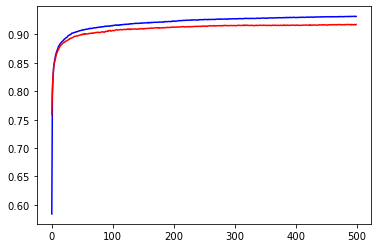

In [44]:
print(classification_report(t_data_test, 
                            (tf.argmax(keras_model.predict(x_data_test), axis=1)).numpy()))
# classification_report의 형식을 맞춰주기 위해 아래와 같이 predict 형식 수정
# (tf.argmax(keras_model.predict(x_data_test), axis=1)).numpy()

import matplotlib.pyplot as plt

history.history.keys()
plt.plot(history.history['sparse_categorical_accuracy'], color='b')
plt.plot(history.history['val_sparse_categorical_accuracy'], color='r')
plt.show()